In [45]:

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np # linear algebra
import pandas as pd # data processing,
import math
import datetime
import platform


The approach will be to generate one distinctive subspace of orthogonal vectors - one U matrix for each class/digit - using Singular Value Decomposition. After creating these matrices, a classifier can be constructed to assign any new unknown image into a class (0, 1, 2, ... ,9).

In [46]:
# data processing
trainImages = pd.DataFrame(pd.read_csv("data/handwriting_training_set.txt"))
trainImagesLabels = pd.DataFrame(pd.read_csv("data/handwriting_training_set_labels.txt"))
testImages = pd.DataFrame(pd.read_csv("data/handwriting_test_set.txt"))
testImagesLabels = pd.DataFrame(pd.read_csv("data/handwriting_test_set_labels.txt"))


In [47]:
print('X_train:', trainImages.shape)
print('y_train:', trainImagesLabels.shape)
print('X_test:', testImages.shape)
print('y_test:', testImagesLabels.shape)

X_train: (3999, 400)
y_train: (3999, 1)
X_test: (999, 400)
y_test: (999, 1)


In [6]:
# Data Overview 
trainImages.head()


,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.168,0.169,0.170,0.171,0.172,0.173,0.174,0.175,0.176,0.177
0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [48]:
trainImages.info() 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Columns: 400 entries, 0 to 0.177
dtypes: float64(392), int64(8)
memory usage: 12.2 MB


In [9]:
trainImages.describe()

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.168,0.169,0.170,0.171,0.172,0.173,0.174,0.175,0.176,0.177
count,3999.0,3999.0,3999.0,3.999000e+03,3.999000e+03,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,...,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3.999000e+03,3999.0
mean,0.0,0.0,0.0,-5.616064e-07,-8.043269e-07,0.000135,0.000116,0.000035,0.000005,0.000056,...,-0.000060,0.000076,0.000172,-0.000025,0.000019,0.000051,0.000011,0.000005,-5.152602e-07,0.0
std,0.0,0.0,0.0,4.044618e-05,2.703821e-04,0.008230,0.007551,0.003923,0.004222,0.004084,...,0.002690,0.006326,0.009447,0.004774,0.004684,0.005172,0.001721,0.000333,3.456721e-05,0.0
min,0.0,0.0,0.0,-2.241932e-03,-1.029667e-02,-0.029396,-0.028706,-0.045485,-0.054957,-0.042550,...,-0.053622,-0.052569,-0.050588,-0.053324,-0.041698,-0.048580,-0.022029,-0.008572,-2.183926e-03,0.0
25%,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
50%,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
75%,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.0
max,0.0,0.0,0.0,5.667892e-04,1.281699e-02,0.506215,0.466290,0.178270,0.246560,0.237271,...,0.079969,0.239926,0.351204,0.251868,0.204862,0.277293,0.075121,0.018903,8.510349e-05,0.0


In [11]:
trainImages.isna().any().any()

False

In [55]:
X = trainImages.iloc[:, 0:400]
y = trainImagesLabels.iloc[:, 0]
X_test = testImages.iloc[:, 0:400]

Visualizing the data using TSNE:

In [104]:
X_tsn = X/255

from sklearn.manifold import TSNE
tsne = TSNE()

tsne_res = tsne.fit_transform(X_tsn)

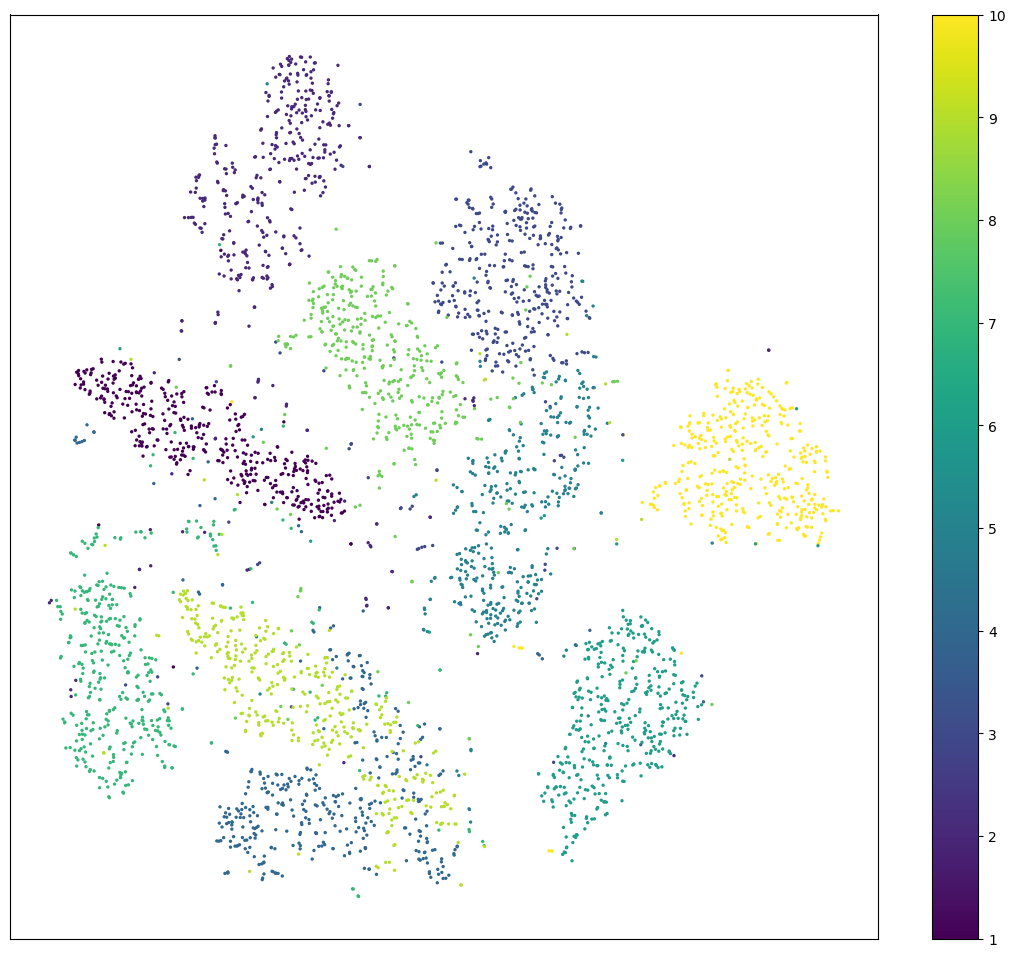

In [57]:
plt.figure(figsize=(14, 12))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar();

Converting data into array:

In [59]:
trainImages_ar = trainImages.to_numpy().reshape(3999, 20, 20)
trainImagesLabels_ar = trainImagesLabels.values
testImages_ar = testImages.to_numpy().reshape(999, 20, 20)
testImagesLabels_ar = testImagesLabels.values


In [60]:
print('X_train:', trainImages_ar.shape)
print('y_train:', trainImagesLabels_ar.shape)
print('X_test:', testImages_ar.shape)
print('y_test:', testImagesLabels_ar.shape)

X_train: (3999, 20, 20)
y_train: (3999, 1)
X_test: (999, 20, 20)
y_test: (999, 1)


In [61]:
# Save image parameters to the constants that we will use later for data re-shaping and for model traning.
(_, IMAGE_WIDTH, IMAGE_HEIGHT) = trainImages_ar.shape
IMAGE_CHANNELS = 1

print('IMAGE_WIDTH:', IMAGE_WIDTH);
print('IMAGE_HEIGHT:', IMAGE_HEIGHT);
print('IMAGE_CHANNELS:', IMAGE_CHANNELS);

IMAGE_WIDTH: 20
IMAGE_HEIGHT: 20
IMAGE_CHANNELS: 1


Explore the data:

In [62]:
pd.DataFrame(trainImages_ar[0])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000323,-0.000916,-0.025353,-0.038593,-0.038404,-0.019375,0.000391,0.000082,0.000000,0.000000,0.0
3,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000117,-0.000825,-0.007053,-0.010966,0.196883,0.320909,0.318912,0.141720,-0.015682,-0.000265,0.000033,0.000000,0.0
4,0.0,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000245,-0.001962,-0.012072,0.005624,0.290347,0.864413,0.988391,0.985527,0.799468,0.156723,-0.017420,0.000539,0.000000,0.0
5,0.0,0.000000e+00,0.000000,0.000000,0.000000,2.385226e-17,-0.001088,-0.029072,0.235754,0.792536,1.002663,1.058621,0.876247,0.929121,1.063432,0.731781,0.035994,-0.013134,0.000404,0.0
6,0.0,0.000000e+00,0.000000,0.000000,0.000245,-1.088474e-03,-0.030273,0.222924,0.856914,1.007231,0.452621,0.422603,0.182431,0.229894,0.763650,0.983979,0.454454,-0.001253,-0.004181,0.0
7,0.0,0.000000e+00,0.000000,0.000020,-0.001188,-1.458408e-02,0.227773,0.849794,1.037872,0.589620,-0.046305,-0.053052,-0.023899,-0.065509,0.497593,1.019261,0.917334,0.106987,-0.016956,0.0
8,0.0,0.000000e+00,0.000000,-0.000092,-0.016771,1.153676e-01,0.806617,1.027307,0.750931,0.101063,-0.020121,0.000135,0.000000,-0.019020,0.272716,0.973519,0.989230,0.134740,-0.019812,0.0
9,0.0,0.000000e+00,0.000000,-0.000866,-0.027240,4.070260e-01,1.014675,0.812185,0.096061,0.000499,0.000009,-0.000047,0.000088,-0.029757,0.451886,1.020129,0.717334,0.045695,-0.010246,0.0


 Visualise how the digits were written:

In [157]:
# Split the training data into individual digit matrices
digit_matrices = []
for i in range(10):
    start_index = i * 400
    end_index = start_index + 400
    digit_matrix = trainImages[start_index:end_index]
    digit_matrices.append(digit_matrix)
trainImages.describe()
trainImages.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Columns: 400 entries, 0 to 0.177
dtypes: float64(392), int64(8)
memory usage: 12.2 MB


In [158]:
# Compute the SVD for each digit matrix
k = 10
digit_svds = []
for digit_matrix in digit_matrices:
    u, s, vt = np.linalg.svd(digit_matrix)
    digit_svds.append((u, s, vt))

In [160]:
# Classify each test digit using SVD
num_basis_vectors = [5, 10, 15, 20]
num_correct = np.zeros(len(num_basis_vectors))
for i in range(len(testImages)):
    test_digit = testImages[i].reshape(400, 20, 20)
    test_u, test_s, test_vt = np.linalg.svd(test_digit)
    distances = []
    for j in range(10):
        class_u, class_s, class_vt = digit_svds[j]
        for k in num_basis_vectors:
            test_reconstructed = (test_u[:, :k] @ np.diag(test_s[:k]) @ test_vt[:k, :]).flatten()
            class_reconstructed = (class_u[:, :k] @ np.diag(class_s[:k]) @ class_vt[:k, :]).flatten()
            distance = np.linalg.norm(test_reconstructed - class_reconstructed)
            distances.append((distance, j))
    distances.sort()
    for j, nbv in enumerate(num_basis_vectors):
        num_correct[j] += int(testImagesLabels[i] == distances[0][1] and nbv == distances[0][1])

# Compute percentage of correctly classified digits
percent_correct = num_correct / len(trainImages) * 100

# Print results
print("Percentage Correctly Classified:")
for i, nbv in enumerate(num_basis_vectors):
    print(f"{nbv} basis vectors: {percent_correct[i]:.2f}%")

KeyError: 0

/Users/zahraaalshalal/anaconda3/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


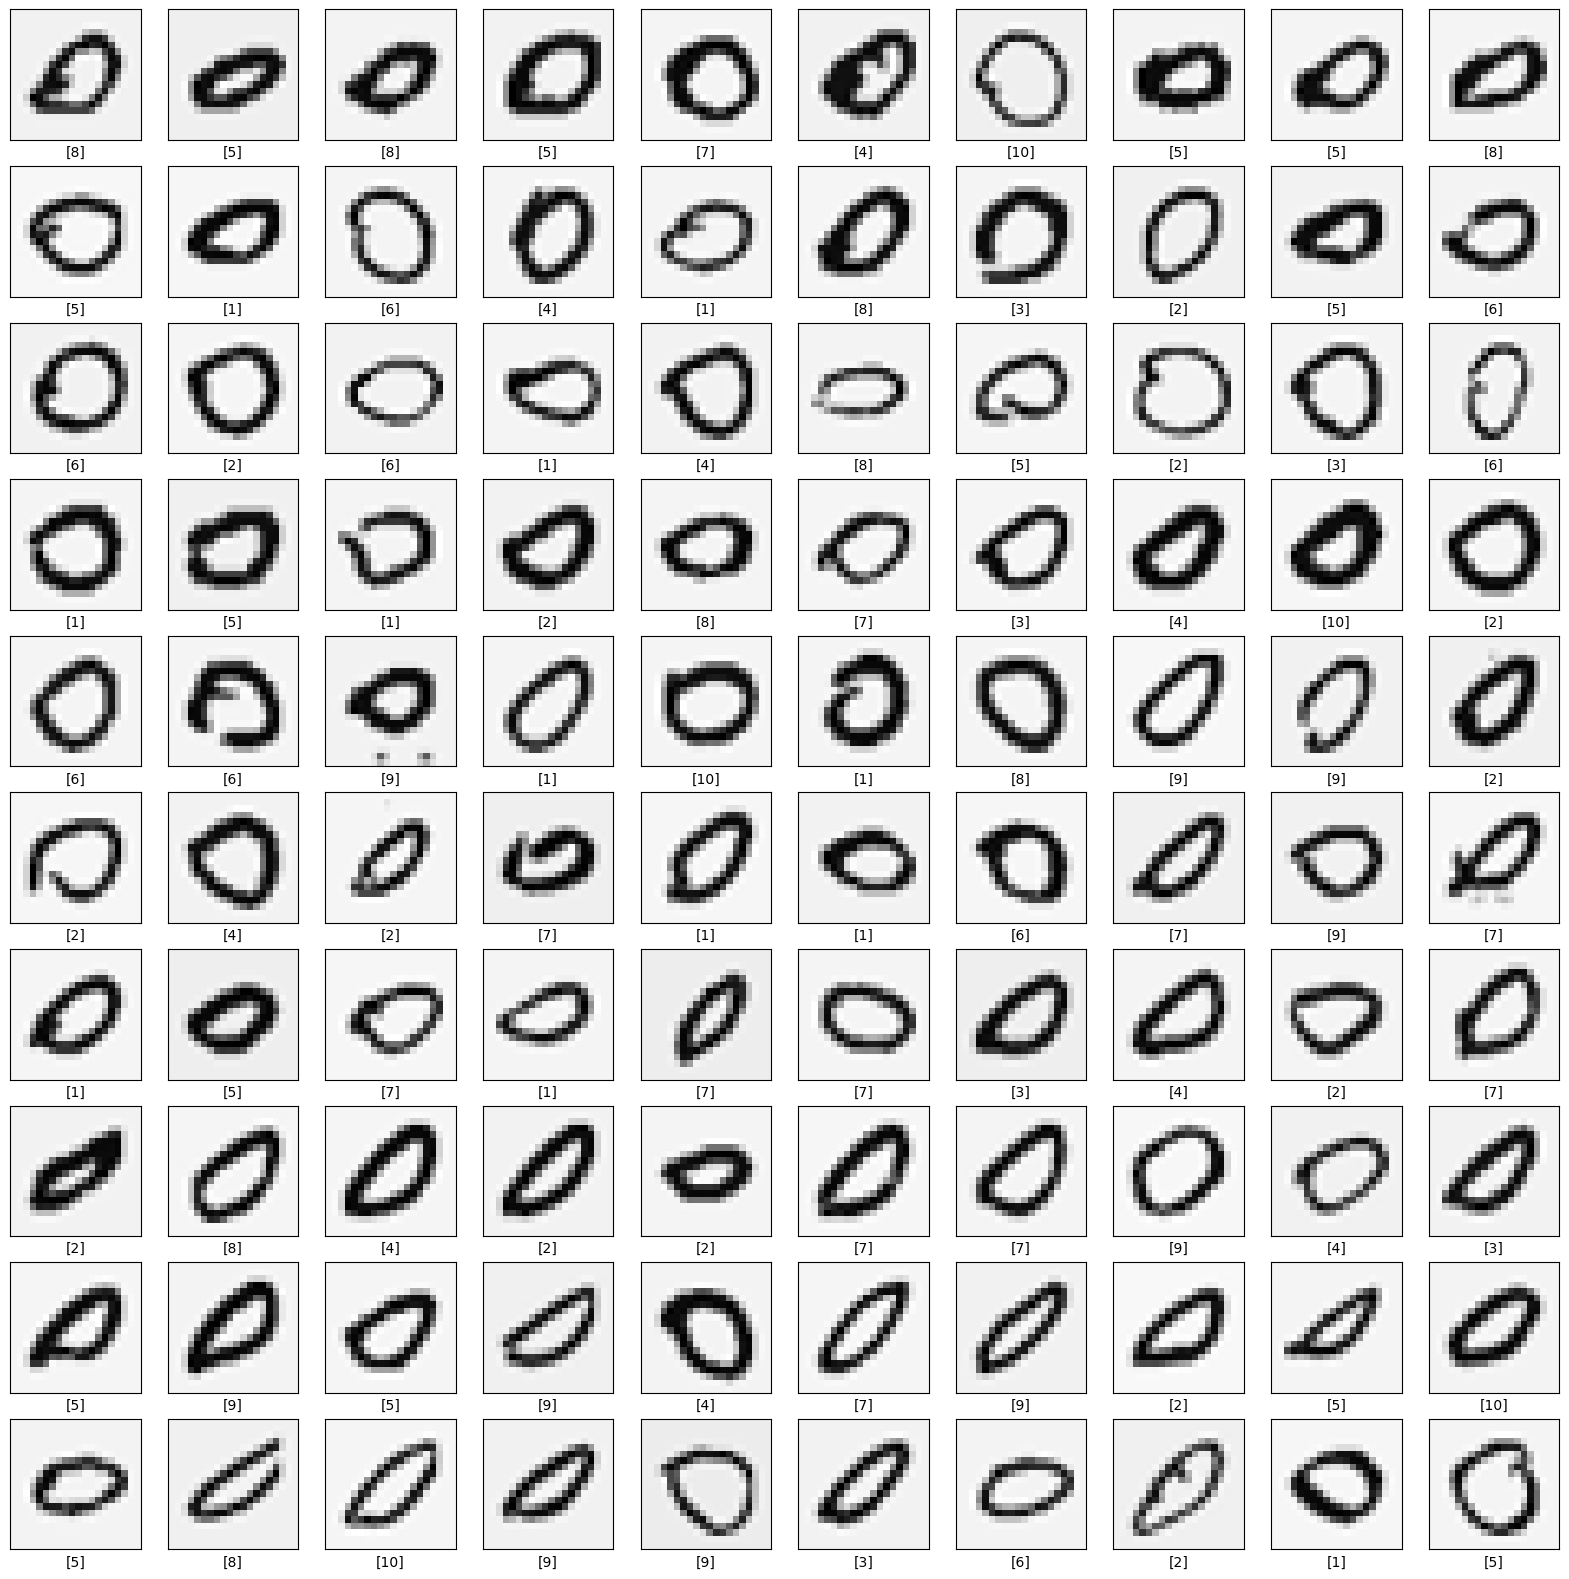

In [129]:
numbers_to_display = 100
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(20,20))
for i in range(numbers_to_display):
    plt.subplot(num_cells, num_cells, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainImages_ar[i], cmap=plt.cm.binary)
    plt.xlabel(testImagesLabels_ar[i])
plt.show()